In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
PEAK_DIR = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/Peaks'
BAM_DIR = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/first_pass_bqsr'
Genotype_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/Called_GT/'
VCF_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/VCF_files'
QTL_dir = '/work-zfs/abattle4/heyuan/Variant_calling/datasets/GBR/ATAC_seq/alignment_bowtie/QTLs'

In [3]:
def compute_RPKM(peaks, bam_stats, samples):
    '''
    Compute RPKM (Reads per kilo base per million mapped reads)
    '''
    read_depth = np.array(bam_stats.set_index('Sample').loc[peaks.columns[4:]]['Reads'])
    peak_width = np.array(peaks['END'] - peaks['START']) / 1e6

    x = np.divide(np.array(peaks[peaks.columns[4:]]) , read_depth)
    RPKM = np.divide(x.transpose(), peak_width).transpose()
    RPKM_dat = pd.DataFrame(RPKM)

    RPKM_dat.columns = samples
    
    RPKM_dat['CHR'] = np.array(peaks['CHR'])
    RPKM_dat['START'] = np.array(peaks['START'])
    RPKM_dat['END'] = np.array(peaks['END'])
    RPKM_dat['PEAK'] = np.array(peaks['PEAK'])
    RPKM_dat = RPKM_dat[['PEAK', 'CHR', 'START', 'END']  + samples]
    RPKM_dat.to_csv('%s/peak_by_sample_matrix_RPKM.txt' % (PEAK_DIR), sep=' ', index = False)
    
    return RPKM_dat


def read_in_peaks():
    bam_stats = pd.read_csv('%s/bam_stats.txt' % BAM_DIR, sep='\t', header=None)
    bam_stats.columns=['Sample', 'Reads']

    try:
        RPKM_dat = pd.read_csv('%s/peak_by_sample_matrix_RPKM.txt' % (PEAK_DIR), sep=' ')
        samples = [x for x in RPKM_dat.columns if x.startswith('HG')]
                
    except:
        print('Read in Peak and convert to RPKM')
        
        # Peaks
        peaks = pd.DataFrame()
        for CHROMOSOME in range(1,23):
            peaks_chr = pd.read_csv('%s/peak_by_sample_matrix_chr%d.txt' % (PEAK_DIR, CHROMOSOME), sep=' ')
            peaks_chr = peaks_chr[[x for x in peaks_chr.columns if 'Unnamed' not in x]]
            peaks = peaks.append(peaks_chr)
            
        samples = [x for x in peaks.columns if x.startswith('HG')]

        # sample read depth
    
        RPKM_dat = compute_RPKM(peaks,bam_stats,samples)

    return [RPKM_dat, bam_stats, samples]

In [4]:
[RPKM_DF, bam_DF, samples] = read_in_peaks()

In [5]:
### PCA correction
from sklearn.decomposition import PCA

centered_dat = np.array(RPKM_DF[samples])
centered_dat = (centered_dat - np.mean(centered_dat, axis=0)) / np.std(centered_dat, axis=0)

pca = PCA(n_components=50)
pca.fit(centered_dat)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

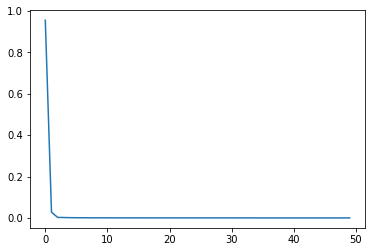

In [35]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(range(50), pca.explained_variance_ratio_)
plt.show()
plt.close()

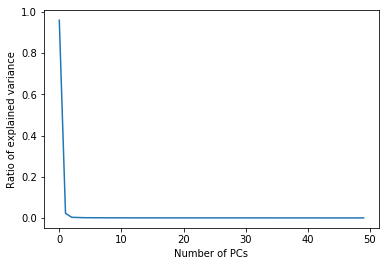

In [7]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(range(50), pca.explained_variance_ratio_)
plt.xlabel('Number of PCs')
plt.ylabel('Ratio of explained variance')
plt.show()
plt.close()

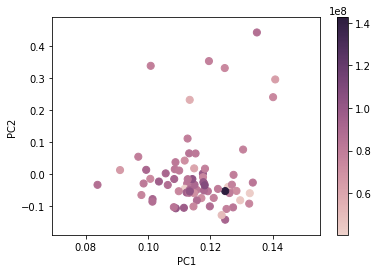

In [38]:
import seaborn as sns

df_plot = pd.DataFrame({"pc1": pca.components_[0,:], 
                        "pc2": pca.components_[1,:], 
                        "read_depth": np.array(bam_DF['Reads'])})

cmap = sns.cubehelix_palette(as_cmap=True)

f, ax = plt.subplots()
points = ax.scatter(df_plot['pc1'], df_plot['pc2'], c=df_plot['read_depth'], s=50, cmap=cmap)
f.colorbar(points)

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()
plt.close()

In [46]:
from sklearn.linear_model import LinearRegression

def remove_PCs(PCA_k, centered_dat):
    
    pca = PCA(n_components=50)
    pca.fit(centered_dat)

    reg = LinearRegression().fit(pca.components_[:PCA_k, :].transpose(), centered_dat.transpose())
    corrected_dat = centered_dat - np.dot(reg.coef_, pca.components_[:PCA_k, :])

    corrected_dat = pd.DataFrame(corrected_dat)
    corrected_dat.columns = samples
    corrected_dat['CHR'] = np.array(RPKM_DF['CHR'])
    corrected_dat['START'] = np.array(RPKM_DF['START'])
    corrected_dat['END'] = np.array(RPKM_DF['END'])
    corrected_dat['PEAK'] = np.array(RPKM_DF['PEAK'])
    corrected_dat = corrected_dat[['PEAK', 'CHR', 'START', 'END']  + samples]
    
    return corrected_dat

In [49]:
#corrected_dat = remove_PCs(PCA_k=3, centered_dat = centered_dat)
for CHROMOSOME in range(1,23):
    corrected_peak_chr = corrected_dat[corrected_dat['CHR'] == CHROMOSOME]
    corrected_peak_chr.to_csv('%s/peak_by_sample_matrix_corrected_chr%d.txt' % (PEAK_DIR, CHROMOSOME), sep='\t', index = False)
    
    